In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt  
import arviz as az
from tqdm import tqdm_notebook as tqdm
import time

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
D:\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [42]:
obsY = None
idxY = None
T = None
K = 22
I = 1
MAXSKILLS = 4

with open('Y.npy', 'rb') as f:
    obsY = np.load(f)
with open('idxY.npy', 'rb') as f:
    idxY = np.load(f)
with open('T.npy', 'rb') as f:
    T = np.load(f)

T = T.tolist()
max_T = max(T)

obsY = obsY.reshape(I, max_T, MAXSKILLS)
idxY = idxY.reshape(I, max_T, MAXSKILLS)
alpha = np.zeros((I, max_T, K), dtype=object)
alphaIdx = np.zeros((I, max_T, K), dtype=object)
prob = np.zeros((I, max_T, K), dtype=object)
Y = np.zeros((I, max_T, K), dtype=object)
py = np.zeros((I, max_T, K), dtype=object)

theta = np.zeros(I, dtype=object)
lambda0 = np.zeros(K, dtype=object)
lambda1 = np.zeros(K, dtype=object)
learn = np.zeros(K, dtype=object)
g = np.zeros(K, dtype=object)
ss = np.zeros(K, dtype=object)
ones = np.zeros(K, dtype=object)

In [43]:
T

[300]

In [44]:
observed_data = {}

for i in range(I):
    observed_data[i] = {}
    for skill_num in range(K):
        observed_data[i][skill_num] = {}
        for t in range(T[i]):
            observed_data[i][skill_num][t] = []

MAXSKILLS = 4
print("USER\tTIMESTEP\tSKILL\tOBSERVATION")
for user_num in range(I):
    
    for t in range(T[user_num]):
        user_obsY = obsY[user_num][t].flatten()
        user_idxY = idxY[user_num][t].flatten()
        
        for l in range(len(user_obsY)):
            obs = int(user_obsY[l])
            skill_num = int(user_idxY[l] - 1)
            
            if skill_num >= 22:
                continue
            
            observed_data[user_num][skill_num][t].append(obs)
        
    t = T[user_num]
    user_obsY = obsY[user_num][:t].flatten()
    user_idxY = idxY[user_num][:t].flatten()
    timestep = -1
    for l in range(len(user_obsY)):
        if l%4 == 0:
            timestep += 1
        skill_num = int(user_idxY[l] - 1)
        if skill_num == 22:
            continue
        obs = int(user_obsY[l])


USER	TIMESTEP	SKILL	OBSERVATION


## Without mini batch

In [45]:
trace = None
summary_df = None
I = 1
K = 10
MAXSKILLS = 4

with pm.Model() as hotDINA:    
    
    # Priors: bk, ak, learn_k, ones, ss_k, g_k
    theta   = pm.Normal('theta', mu=0.0, sd=1.0, shape=(I, 1))
    lambda0 = pm.Normal('lambda0', mu=0.0, sd=1.0, shape=(K, 1))    #bk
    lambda1 = pm.Uniform('lambda1', 0.0, 2.5, shape=(K, 1))    #ak
    learn   = pm.Beta('learn', alpha=1, beta=1, shape=(K, 1))
    ones    = pm.Bernoulli('known', p=1, shape=(K, 1))
    ss      = pm.Uniform('ss', 0.5, 1.0, shape=(K, 1))
    g       = pm.Uniform('g', 0, 0.5, shape=(K, 1))
    
    for i in range(I):
        # t = 0
        for k in range(K):
            prob[i][0][k] = pm.math.invlogit((1.7) * lambda1[k,0] * (theta[i,0] - lambda0[k,0]))
            alpha_name = 'alpha[' + str(i) + ',0,' + str(k) + ']'
            alpha[i][0][k] = pm.Bernoulli(alpha_name, prob[i][0][k])
            
        for s in range(MAXSKILLS):
            idx = int(idxY[i][0][s] - 1)
            if idx >= K: continue
            py[i][0][idx] = pow(ss[idx,0], alpha[i][0][idx]) * pow(g[idx,0], (1-alpha[i][0][idx]))
        
        # t = 1,2...T[i]-1
        for t in tqdm(range(1, T[i])):
            for k in range(K):
                alpha_name = 'alpha[' + str(i) + ',+' str(t) '+,' + str(k) + ']'
                alpha[i][t][k] = pm.Bernoulli(alpha_name, pm.math.switch(alpha[i][t-1][k], 1, learn[k,0]))
                
            for s in range(MAXSKILLS):
                idx = int(idxY[i][t][s] - 1)
                if idx >= K: continue
                py[i][t][idx] = pow(ss[idx,0], alpha[i][t][idx]) * pow(g[idx,0], (1-alpha[i][t][idx]))
    
        start = time.time()
        for t in tqdm(range(T[i])):
            for k in range(K):
                if py[i][t][k] != 0:
                    Y[i][t][k] = pm.Bernoulli(f'y_{i}_{t}_{k}', p=py[i][t][k], observed=[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        end = time.time()
        res = (end - start)/T[i]
        print("TIME w/o mini batch: ", res)

    print("DONE")
    trace = pm.sample(1000, tune=500)
    pm.save_trace(trace=trace, directory=".pymc_1.trace", overwrite=True)
    pm.traceplot(trace, ['theta', 'lambda0', 'lambda1'])
    summary_df = pm.stats.summary(trace)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



TIME w/o mini batch:  0.04129650036493937
DONE


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [g, ss, learn, lambda1, lambda0, theta]
>BinaryGibbsMetropolis: [known, alpha[0,0,0], alpha[0,0,1], alpha[0,0,2], alpha[0,0,3], alpha[0,0,4], alpha[0,0,5], alpha[0,0,6], alpha[0,0,7], alpha[0,0,8], alpha[0,0,9]]


RecursionError: maximum recursion depth exceeded while pickling an object

In [26]:
advi_trace = trace
summary_df = pm.stats.summary(advi_trace)

D:\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [27]:
summary_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"theta[0,0]",-0.378,0.922,-1.934,1.007,0.183,0.137,25.0,23.0,31.0,39.0,1.20
"lambda0[0,0]",-0.044,1.062,-2.334,1.307,0.138,0.107,59.0,50.0,64.0,30.0,1.06
"lambda0[1,0]",-0.046,1.037,-2.134,1.519,0.177,0.127,34.0,34.0,34.0,61.0,1.12
"lambda0[2,0]",0.102,0.889,-1.241,1.697,0.188,0.135,22.0,22.0,23.0,28.0,1.21
"known[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,40.0,40.0,40.0,40.0,NaN
"known[1,0]",1.000,0.000,1.000,1.000,0.000,0.000,40.0,40.0,40.0,40.0,NaN
"known[2,0]",1.000,0.000,1.000,1.000,0.000,0.000,40.0,40.0,40.0,40.0,NaN
"alpha[0,0,0]",0.350,0.483,0.000,1.000,0.088,0.063,30.0,30.0,30.0,30.0,1.09
"alpha[0,0,1]",0.500,0.506,0.000,1.000,0.098,0.070,26.0,26.0,26.0,26.0,1.19
"alpha[0,0,2]",0.375,0.490,0.000,1.000,0.117,0.084,18.0,18.0,18.0,18.0,1.29


D:\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002394FB6BC88>,
      dtype=object)

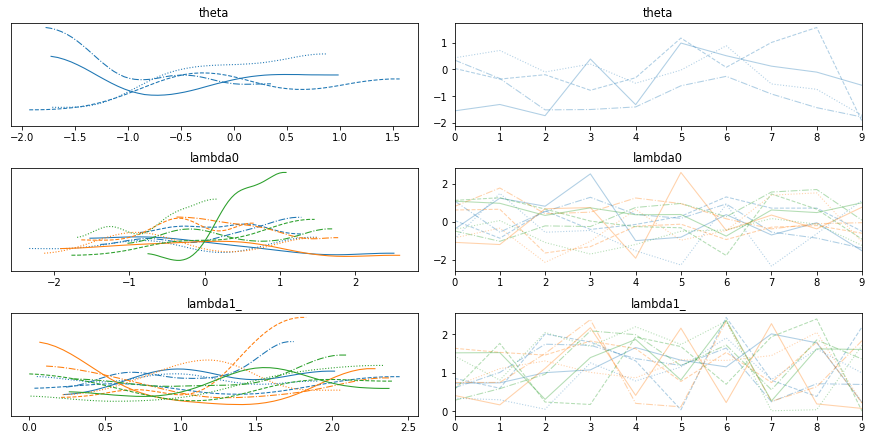

In [37]:
pm.traceplot(advi_trace, ['theta', 'lambda0', 'lambda1_'])

In [41]:
T

[100]

In [38]:
trace = None
summary_df = None

K = 22

with pm.Model() as hotDINA:    
    # Priors: theta, bk, ak, learn_k, ones, ss_k, g_k
    theta   = pm.Normal('theta', mu=0.0, sd=1.0, shape=(I, 1))
    lambda0 = pm.Normal('lambda0', mu=0.0, sd=1.0, shape=(K, 1))    #bk
    lambda1 = pm.Uniform('lambda1_', 0.0, 2.5, shape=(K, 1))    #ak
    learn   = pm.Beta('learn', alpha=1, beta=1, shape=(K, 1))
    ones    = pm.Bernoulli('known', p=1, shape=(K, 1))
    ss      = pm.Uniform('ss', 0.5, 1.0, shape=(K, 1))
    g       = pm.Uniform('g', 0, 0.5, shape=(K, 1))
    for i in range(I):
        # t = 0
        for k in range(K):
            prob[i][0][k] = pm.math.invlogit((1.7) * lambda1[k,0] * (theta[i,0] - lambda0[k,0]))
            alpha_name = 'alpha[' + str(i) + ',0,' + str(k) + ']'
            alpha[i][0][k] = pm.Bernoulli(alpha_name, prob[i][0][k])
            
        for s in range(MAXSKILLS):
            idx = int(idxY[i][0][s] - 1)
            if idx >= 22: continue
            py[i][0][idx] = pow(ss[idx,0], alpha[i][0][idx]) * pow(g[idx,0], (1-alpha[i][0][idx]))
        
        # t = 1,2...T[i]-1
        for t in tqdm(range(1, T[i])):
            for k in range(K):
                alpha[i][t][k] = pm.math.switch(alpha[i][t-1][k], ones[k,0], learn[k,0])
                
            for s in range(MAXSKILLS):
                idx = int(idxY[i][t][s] - 1)
                if idx >= 22: continue
                py[i][t][idx] = pow(ss[idx,0], alpha[i][t][idx]) * pow(g[idx,0], (1-alpha[i][t][idx]))
    
        start = time.time()
        for t in tqdm(range(T[i])):
            for s in range(MAXSKILLS):
                idx = int(idxY[i][t][s] - 1)
                if idx >= 22: continue
                Y[i][t][idx] = pm.Bernoulli(f'y_{i}_{t}_{idx}', p=py[i][t][idx], observed=observed_data[i][idx][t])
        end = time.time()
        res = (end - start)/T[i]
        print("TIME w/o mini batch; using s instead of k: ", res)

    print("DONE")
    trace = pm.sample(10)
#     pm.save_trace(trace=trace, directory=".pymc_1.trace", overwrite=True)
    pm.traceplot(trace, ['theta', 'lambda0', 'lambda1'])
    summary_df = pm.stats.summary(trace)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Only 10 samples in chain.



TIME w/o mini batch; using s instead of k:  0.10257291793823242
DONE


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [g, ss, learn, lambda1_, lambda0, theta]
>BinaryGibbsMetropolis: [known, alpha[0,0,0], alpha[0,0,1], alpha[0,0,2], alpha[0,0,3], alpha[0,0,4], alpha[0,0,5], alpha[0,0,6], alpha[0,0,7], alpha[0,0,8], alpha[0,0,9], alpha[0,0,10], alpha[0,0,11], alpha[0,0,12], alpha[0,0,13], alpha[0,0,14], alpha[0,0,15], alpha[0,0,16], alpha[0,0,17], alpha[0,0,18], alpha[0,0,19], alpha[0,0,20], alpha[0,0,21]]


RecursionError: maximum recursion depth exceeded

In [39]:
batch_size = 100

with pm.Model() as hotDINA:    
    
    # Priors: bk, ak, learn_k, ones, ss_k, g_k
    theta   = pm.Normal('theta', mu=0.0, sd=1.0, shape=(I, 1))
    lambda0 = pm.Normal('lambda0', mu=0.0, sd=1.0, shape=(K, 1))    #bk
    lambda1 = pm.Uniform('lambda1', 0.0, 2.5, shape=(K, 1))    #ak
    learn   = pm.Beta('learn', alpha=1, beta=1, shape=(K, 1))
    ones    = pm.Bernoulli('known', p=1, shape=(K, 1))
    ss      = pm.Uniform('ss', 0.5, 1.0, shape=(K, 1))
    g       = pm.Uniform('g', 0, 0.5, shape=(K, 1))
    
        
    for i in range(I):
        # t = 0
        for k in range(K):
            prob[i][0][k] = pm.math.invlogit((1.7) * lambda1[k,0] * (theta[i,0] - lambda0[k,0]))
            alpha_name = 'alpha[' + str(i) + ',0,' + str(k) + ']'
            alpha[i][0][k] = pm.Bernoulli(alpha_name, prob[i][0][k])
            
        for s in range(MAXSKILLS):
            idx = int(idxY[i][0][s] - 1)
            if idx >= K: continue
            py[i][0][idx] = pow(ss[idx,0], alpha[i][0][idx]) * pow(g[idx,0], (1-alpha[i][0][idx]))
        
        # t = 1,2...T[i]-1
        for t in tqdm(range(1, T[i])):
            for k in range(K):
                alpha[i][t][k] = pm.math.switch(alpha[i][t-1][k], ones[k,0], learn[k,0])
                
            for s in range(MAXSKILLS):
                idx = int(idxY[i][t][s] - 1)
                if idx >= K: continue
                py[i][t][idx] = pow(ss[idx,0], alpha[i][t][idx]) * pow(g[idx,0], (1-alpha[i][t][idx]))
    
        start = time.time()
        for t in tqdm(range(T[i])):
            for k in range(K):
                if py[i][t][k] != 0:
                    obs_data_batch = pm.Minibatch(observed_data[i][k][t], batch_size=batch_size) 
                    Y[i][t][k] = pm.Bernoulli(f'y_{i}_{t}_{k}', p=py[i][t][k], observed=obs_data_batch)
        
        end = time.time()
        res = (end - start)/T[i]
        print("TIME: with mini batch", res)
    print("DONE")
    trace = pm.sample(10)
#     pm.save_trace(trace=trace, directory=".pymc_1.trace", overwrite=True)
    pm.traceplot(trace, ['theta', 'lambda0', 'lambda1'])
    summary_df = pm.stats.summary(trace)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


D:\anaconda3\lib\site-packages\pymc3\data.py:307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
Only 10 samples in chain.



TIME: with mini batch 5.247637660503387
DONE


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [g, ss, learn, lambda1, lambda0, theta]
>BinaryGibbsMetropolis: [known, alpha[0,0,0], alpha[0,0,1], alpha[0,0,2], alpha[0,0,3], alpha[0,0,4], alpha[0,0,5], alpha[0,0,6], alpha[0,0,7], alpha[0,0,8], alpha[0,0,9], alpha[0,0,10], alpha[0,0,11], alpha[0,0,12], alpha[0,0,13], alpha[0,0,14], alpha[0,0,15], alpha[0,0,16], alpha[0,0,17], alpha[0,0,18], alpha[0,0,19], alpha[0,0,20], alpha[0,0,21]]


RecursionError: maximum recursion depth exceeded

In [113]:
obsY.shape

(2, 2993, 4)

In [101]:
observed_data[0]

{0: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 1: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 2: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 3: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 4: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 5: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 6: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 7: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 8: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 9: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 10: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 11: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 12: {0: [0.0], 1: [1.0], 2: [0.0], 3: [0.0], 4: [0.0], 5: [0.0], 6: [1.0]},
 13: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 14: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 15: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 16: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []},
 17: {0: [], 1: [], 2: [], 3: [], 4: 

In [19]:
trace = None
T = 8
I = 3

py = np.zeros((I, T), dtype=object)
prob = np.zeros(I, dtype=object)

# Priors
theta = np.zeros(I, dtype=object)
a = np.zeros(I, dtype=object)
b = np.zeros(I, dtype=object)
g = np.zeros(I, dtype=object)
ss = np.zeros(I, dtype=object)
learn = np.zeros(I, dtype=object)
ones = np.zeros(I, dtype=object)

# Likelihoods/conditional nodes
Y = np.zeros((I, T), dtype=object)
alpha = np.zeros((I, T), dtype=object)

# Fake observation data
obs_data = []
data_pts = 20
for i in range(data_pts):
    obs_data.append(np.random.choice(2))

# Model
with pm.Model() as hotDINA:
    for i in range(I):
        theta[i] = pm.Normal('theta_' + str(i), mu=0.0, sd=1.0)
        a[i] = pm.Uniform("a_" + str(i), 0.0, 2.5)
        b[i] = pm.Normal('b_' + str(i), mu=0.0, sd=1.0)
        g[i] = pm.Uniform("g_" + str(i), 0.0, 0.5)
        ss[i] = pm.Uniform("ss_" + str(i), 0.5, 1.0)
        learn[i] = pm.Beta('learn_' + str(i), alpha=1, beta=1)
        ones[i] = pm.Bernoulli('known_' + str(i), p=1)
        
        prob[i] = pm.math.invlogit(1.7 * a[i] * (theta[i] - b[i]))
        alpha[i][0] = pm.Bernoulli('alpha0_' + str(i), prob[i])
        
        py[i][0] = pow(ss[i], alpha[i][0]) * pow(g[i], 1-alpha[i][0])
    
    for i in range(I):
        for t in tqdm(range(1, T)):
            known = pm.Bernoulli(f'known_{i}_{t}', ones[i])
            bern = pm.Bernoulli(f'learn_{i}_{t}', learn[i])
            alpha[i][t] = pm.math.switch(alpha[i][t-1], bern, known)
            
            py[i][t] = pow(ss[i], alpha[i][t]) * pow(g[i], (1-alpha[i][t]))
    
    for i in range(I):
        for t in range(T):
            Y[i][t] = pm.Bernoulli(f'Y_{i}_{t}', p=py[i][t], observed=obs_data)
    print("DONE")
    trace = pm.sample(10)
            

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Only 10 samples in chain.


DONE


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [learn_19, ss_19, g_19, b_19, a_19, theta_19, learn_18, ss_18, g_18, b_18, a_18, theta_18, learn_17, ss_17, g_17, b_17, a_17, theta_17, learn_16, ss_16, g_16, b_16, a_16, theta_16, learn_15, ss_15, g_15, b_15, a_15, theta_15, learn_14, ss_14, g_14, b_14, a_14, theta_14, learn_13, ss_13, g_13, b_13, a_13, theta_13, learn_12, ss_12, g_12, b_12, a_12, theta_12, learn_11, ss_11, g_11, b_11, a_11, theta_11, learn_10, ss_10, g_10, b_10, a_10, theta_10, learn_9, ss_9, g_9, b_9, a_9, theta_9, learn_8, ss_8, g_8, b_8, a_8, theta_8, learn_7, ss_7, g_7, b_7, a_7, theta_7, learn_6, ss_6, g_6, b_6, a_6, theta_6, learn_5, ss_5, g_5, b_5, a_5, theta_5, learn_4, ss_4, g_4, b_4, a_4, theta_4, learn_3, ss_3, g_3, b_3, a_3, theta_3, learn_2, ss_2, g_2, b_2, a_2, theta_2, learn_1, ss_1, g_1, b_1, a_1, theta_1, learn_0, ss_0, g_0, b_0, a_0, theta_0]
>BinaryGibbsMetropolis: [known_0, alpha0_0, known_1, alpha0_1, known_2, alpha0_2, known_3, alpha

RecursionError: maximum recursion depth exceeded while pickling an object

In [75]:
I = 3
trace = None
T = 8
I = 20

py = np.zeros((I, T), dtype=object)
prob = np.zeros(I, dtype=object)

# Priors
theta = np.zeros(I, dtype=object)
a = np.zeros(I, dtype=object)
b = np.zeros(I, dtype=object)
g = np.zeros(I, dtype=object)
ss = np.zeros(I, dtype=object)
learn = np.zeros(I, dtype=object)
ones = np.zeros(I, dtype=object)

# Likelihoods/conditional nodes
Y = np.zeros((I, T), dtype=object)
alpha_0 = np.zeros((I, 1), dtype=object)
alpha = np.zeros((I, T), dtype=object)
vec = None

# Fake observation data
obs_data = []
data_pts = 20
for i in range(data_pts):
    obs_data.append(np.random.choice(2))
with pm.Model() as hotDINA:
    
    theta = pm.Normal('theta', mu=0.0, sd=1.0, shape=(I, 1))
    a = pm.Uniform("a", 0.0, 2.5, shape=(I, 1))
    b = pm.Normal('b', mu=0.0, sd=1.0, shape=(I, 1))
    g = pm.Uniform("g", 0.0, 0.5, shape=(I, 1))
    ss = pm.Uniform("ss", 0.5, 1.0, shape=(I, 1))
    learn = pm.Beta('learn', alpha=1, beta=1, shape=(I, 1))
    ones = pm.Bernoulli('known', p=1, shape=(I, 1))
    
    for i in range(I):
        prob[i] = pm.math.invlogit(1.7 * a[i,0] * (theta[i,0] - b[i,0]))
        alpha[i][0] = pm.Bernoulli(f'alpha_{0}_{i}', prob[i])
        py[i][0] = pow(ss[i,0], alpha[i][0]) * pow(g[i,0], 1-alpha[i][0])
        
        Y[i][0] = pm.Bernoulli(f'Y_{i}_{0}', p=py[i][0], observed=obs_data)
        
        for t in range(1, T):
            alpha[i][t] = pm.math.switch(alpha[i][t-1], ones[i,0], learn[i,0])
            py[i][t] = pow(ss[i,0], alpha[i][t]) * pow(g[i,0], 1-alpha[i][t])
            Y[i][t] = pm.Bernoulli(f'Y_{i}_{t}', p=py[i][t], observed=obs_data)
    
    trace = pm.sample(10)

Only 10 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [learn, ss, g, b, a, theta]
>BinaryGibbsMetropolis: [known, alpha_0_0, alpha_0_1, alpha_0_2, alpha_0_3, alpha_0_4, alpha_0_5, alpha_0_6, alpha_0_7, alpha_0_8, alpha_0_9, alpha_0_10, alpha_0_11, alpha_0_12, alpha_0_13, alpha_0_14, alpha_0_15, alpha_0_16, alpha_0_17, alpha_0_18, alpha_0_19]


ValueError: Not enough samples to build a trace.

In [69]:
prob[0]

Elemwise{add,no_inplace}.0

In [62]:
tt.printing.Print('prob')(prob[0].shape)

prob __str__ = [1]


Print{message='prob', attrs=('__str__',), global_fn=<function _print_fn at 0x0000022C7972A288>}.0

In [96]:
K

21